<a href="https://colab.research.google.com/github/F0lty/Instrument-Classification/blob/main/Copy_of_First_CNN_on_mel_spec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Imports**

In [1]:
!pip install -U -q PyDrive

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import librosa, librosa.display
import tensorflow as tf
from tensorflow.keras import layers
from scipy.io import wavfile
import os
import numpy as np
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as MNV2
from tensorflow.keras import metrics
import tensorflow_hub as hub
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#**Authenticate Drive**

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Download files

In [5]:
downloaded = drive.CreateFile({'id':"1X_rOwyOlKKayo0rEYmOIr08SYDusgpP_"})
print(downloaded)

GoogleDriveFile({'id': '1X_rOwyOlKKayo0rEYmOIr08SYDusgpP_'})


In [7]:
basepath = 'drive/MyDrive/Colab Notebooks'
folders = os.listdir("{}/mono".format(basepath))
print(folders) #see availible classes

['cel', 'vio', 'flu', 'sax', 'tru', 'org', 'cla', 'gac', 'pia', 'gel', 'voi']


Create Mel-spectograms from audio files and save them on drive (need to run just once)

In [9]:
for i,entry in enumerate(folders):                                                         #Go through all folders containing audio
    exists = os.path.exists("{}/images/{}".format(basepath, entry))                        #In case the folder is already there, skip it and convert files of other folders
    if not exists:
        files = os.listdir("{}/mono/{}".format(basepath,entry)) 
        os.mkdir("{}/images/{}".format(basepath, entry))                                   #Create a folder for an instrument
        counter = 0
        for a, filderos in enumerate(files):                                                #Go through all of the audio files ina  folder
            plt.figure(figsize=(2.24, 2.24))                                                #Rest of this code: Create a matplotlib fig, load files with librosa, create a mel spectrogram and save it to a correct folder
            plt.subplots_adjust(left=0, right=1, bottom=0, top=1)#This lise crops the plot so we save only the content of the fig not axes
            y, sr = librosa.load('{}/mono/{}/{}'.format(basepath,entry,filderos))
            S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, n_mels=256)
            S_DB = librosa.power_to_db(S, ref=np.max)
            librosa.display.specshow(S_DB, sr=sr)
            plt.savefig('{}/images/{}/{}.png'.format(basepath,entry,filderos), dpi=80)
            plt.close()                                 
            counter +=1 #This counter is here mainly for debug purposes - to see the progress but also can be used to limit the amount of spectrograms created - if counter == x: break
            print(counter)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


Some more variables for further work

In [10]:
basepath = 'drive/MyDrive/Colab Notebooks/images'
batch_size = 50
image_height = 224 #Size expected by the pretrained model
image_width = 224

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory( #Lazy coding here, while using Keras reading the images from disk and splitting them straight away to train and validation while shuffeling the data as well
  basepath,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=batch_size)
print(train_ds)

Found 2495 files belonging to 4 classes.
Using 1996 files for training.
<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  basepath,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=batch_size)

Found 2495 files belonging to 4 classes.
Using 499 files for validation.


In [13]:
class_names = train_ds.class_names #Just checking the actual classes before going further
print(class_names)

['cel', 'gel', 'pia', 'sax']


# Building the model
This code helps with loading the images - once they are loaded in a memory, we dont need to load them from drive anymore

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 4 #Limited to 4 out of 11 as the model performes much better - those 4 are the most distinctive and easiest to recognise

The model itself using MobileNetV2

In [15]:
modelBase = MNV2(input_shape=(image_height, image_width, 3),
include_top=False, weights='imagenet')
for i, layer in enumerate(modelBase.layers):
    layer.trainable = False
model = modelBase.layers[-3].output
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)(model)

# define a new model
modelFinal = tf.keras.Model(modelBase.input, model)

9412608/9406464 [==============================] - 0s 0us/step


Compile

In [16]:
modelFinal.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

And finally training

In [17]:
history = modelFinal.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30,
  verbose=1
)

Epoch 1/30
40/40 [==============================] - 473s 9s/step - loss: 1.3216 - accuracy: 0.3812 - val_loss: 1.2369 - val_accuracy: 0.5010
Epoch 2/30
40/40 [==============================] - 3s 72ms/step - loss: 1.2292 - accuracy: 0.5168 - val_loss: 1.2145 - val_accuracy: 0.5150
Epoch 3/30
40/40 [==============================] - 3s 72ms/step - loss: 1.1970 - accuracy: 0.5507 - val_loss: 1.1801 - val_accuracy: 0.5571
Epoch 4/30
40/40 [==============================] - 3s 73ms/step - loss: 1.1679 - accuracy: 0.5891 - val_loss: 1.1654 - val_accuracy: 0.5752
Epoch 5/30
40/40 [==============================] - 3s 72ms/step - loss: 1.1524 - accuracy: 0.6013 - val_loss: 1.1553 - val_accuracy: 0.6012
Epoch 6/30
40/40 [==============================] - 3s 72ms/step - loss: 1.1422 - accuracy: 0.6173 - val_loss: 1.1484 - val_accuracy: 0.5972
Epoch 7/30
40/40 [==============================] - 3s 73ms/step - loss: 1.1351 - accuracy: 0.6219 - val_loss: 1.1433 - val_accuracy: 0.5972
Epoch 8/30
40

In [ ]:
history.history
modelFinal.save(basepath)

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/images/assets


Plotting the results - based on those we can tell 

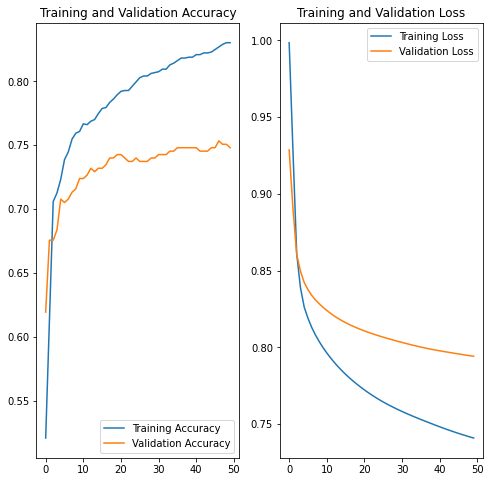

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

In [33]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'drive/MyDrive/Colab Notebooks/imagesTest',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=batch_size)
predictions = modelFinal.predict(test_ds)


Found 90 files belonging to 3 classes.
Using 18 files for validation.


In [22]:
print(predictions)

[[8.09312798e-04 9.64975476e-01 1.29520602e-03 3.29200663e-02]
 [9.98389482e-01 1.96147403e-06 1.02681706e-05 1.59836095e-03]
 [3.84245242e-04 9.91184771e-01 2.65426980e-03 5.77667402e-03]
 [9.90482926e-01 4.40395706e-06 1.60120006e-04 9.35261045e-03]
 [4.91157407e-05 1.55721521e-02 9.11949813e-01 7.24288225e-02]
 [2.48667300e-01 1.10148840e-05 2.61423327e-02 7.25179374e-01]
 [6.72086358e-01 7.80265909e-05 1.88471660e-01 1.39363959e-01]
 [9.16655421e-01 1.85790515e-04 9.14264470e-04 8.22445899e-02]
 [2.79812026e-04 3.27497837e-05 9.89311635e-01 1.03758648e-02]
 [7.74867058e-01 6.77447533e-05 5.49345016e-02 1.70130700e-01]
 [5.71865439e-01 7.04663876e-07 5.94271794e-02 3.68706763e-01]
 [3.93685696e-05 7.98768103e-01 1.53907195e-01 4.72853817e-02]
 [9.98013139e-01 2.02630163e-10 4.97328729e-05 1.93714222e-03]
 [3.22195212e-03 1.24083003e-02 9.23026919e-01 6.13428131e-02]
 [1.00200565e-03 2.31529717e-04 9.95872080e-01 2.89430656e-03]
 [8.87197559e-04 9.49393988e-01 1.51393730e-02 3.457948